In [1]:
import glob
import os
import sys

try:
    sys.path.append(glob.glob('PythonAPI/carla/dist/carla-*%d.%d-%s.egg' % (
        sys.version_info.major,
        sys.version_info.minor,
        'win-amd64' if os.name == 'nt' else 'linux-x86_64'))[0])
except IndexError:
    pass

import carla
import random
import cv2
import skimage.measure as measure

#in synchronous mode, sensor data must be added to a queue
import queue



In [2]:
client = carla.Client('localhost', 2000)
client.set_timeout(11.0)

In [3]:
print(client.get_available_maps())

['/Game/Carla/Maps/Town05_Opt', '/Game/Carla/Maps/Town02', '/Game/Carla/Maps/Town10HD_Opt', '/Game/Carla/Maps/Town04', '/Game/Carla/Maps/Town05', '/Game/Carla/Maps/Town03_Opt', '/Game/Carla/Maps/Town10HD', '/Game/Carla/Maps/Town04_Opt', '/Game/Carla/Maps/Town01', '/Game/Carla/Maps/Town03', '/Game/Carla/Maps/Town02_Opt', '/Game/Carla/Maps/Town01_Opt']


In [4]:
world = client.load_world('Town03')

In [5]:
settings = world.get_settings()

In [6]:
weather = carla.WeatherParameters(
    cloudiness=20.0,
    precipitation=20.0,
    sun_altitude_angle=110.0)


In [7]:
world.set_weather(weather)

In [8]:
blueprints = world.get_blueprint_library().filter('*')
for blueprint in random.sample(list(blueprints), 5):
    print(blueprint.id)
    for attr in blueprint:
       print('  - {}'.format(attr))

static.prop.garbage06
  - ActorAttribute(id=size,type=str,value=tiny(const))
  - ActorAttribute(id=ros_name,type=str,value=static.prop.garbage06)
  - ActorAttribute(id=role_name,type=str,value=prop)
walker.pedestrian.0010
  - ActorAttribute(id=generation,type=int,value=1(const))
  - ActorAttribute(id=gender,type=str,value=female(const))
  - ActorAttribute(id=age,type=str,value=child(const))
  - ActorAttribute(id=is_invincible,type=bool,value=True)
  - ActorAttribute(id=ros_name,type=str,value=walker.pedestrian.0010)
  - ActorAttribute(id=speed,type=float,value=0)
  - ActorAttribute(id=role_name,type=str,value=pedestrian)
static.prop.box03
  - ActorAttribute(id=size,type=str,value=small(const))
  - ActorAttribute(id=ros_name,type=str,value=static.prop.box03)
  - ActorAttribute(id=role_name,type=str,value=prop)
sensor.camera.instance_segmentation
  - ActorAttribute(id=lens_y_size,type=float,value=0.08)
  - ActorAttribute(id=lens_kcube,type=float,value=0)
  - ActorAttribute(id=lens_circle

In [6]:
actor_list = []

In [7]:
blueprint_library = world.get_blueprint_library()
bp = random.choice(blueprint_library.filter('vehicle')) # lets choose a vehicle at random

# lets choose a random spawn point
transform = random.choice(world.get_map().get_spawn_points()) 

#spawn a vehicle
vehicle = world.spawn_actor(bp, transform) 
actor_list.append(vehicle)

vehicle.set_autopilot(True)

In [ ]:
#lets create waypoints for driving the vehicle around automatically
m= world.get_map()
waypoint = m.get_waypoint(transform.location)

#lets add more vehicles
for _ in range(0, 200):
    transform = random.choice(m.get_spawn_points())

    bp_vehicle = random.choice(blueprint_library.filter('vehicle'))

    # This time we are using try_spawn_actor. If the spot is already
    # occupied by another object, the function will return None.
    other_vehicle = world.try_spawn_actor(bp_vehicle, transform)
    if other_vehicle is not None:
        #print(npc)
        other_vehicle.set_autopilot(True)
        actor_list.append(other_vehicle)

In [11]:
blueprint_library = world.get_blueprint_library()
weirdobj_bp = blueprint_library.find('static.prop.fountain')
weirdobj_transform = random.choice(world.get_map().get_spawn_points())
weirdobj_transform = carla.Transform(carla.Location(x=230, y=195, z=40), carla.Rotation(yaw=180))
weird_obj = world.try_spawn_actor(weirdobj_bp, weirdobj_transform)
actor_list.append(weird_obj)

In [11]:
#example for getting camera image
camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
image_queue = queue.Queue()
camera.listen(image_queue.put)
actor_list.append(camera)

#example for getting depth camera image
camera_depth = blueprint_library.find('sensor.camera.depth')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
camera_d = world.spawn_actor(camera_depth, camera_transform, attach_to=vehicle)
image_queue_depth = queue.Queue()
camera_d.listen(image_queue_depth.put)
actor_list.append(camera_d)

#example for getting semantic segmentation camera image
camera_semseg = blueprint_library.find('sensor.camera.semantic_segmentation')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
camera_seg = world.spawn_actor(camera_semseg, camera_transform, attach_to=vehicle)
image_queue_seg = queue.Queue()
camera_seg.listen(image_queue_seg.put)
actor_list.append(camera_seg)

In [12]:
# Some helper functions we will need later. Feel free to skip this for now to the next section.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pycocotools
import math
from scipy.spatial import distance

def get_mask(seg_im, rgb_value):
    # rgb_value should be somethiing like np.uint8([[[70, 70, 70]]])
    # seg_im should be in HSV
    
    hsv_value = cv2.cvtColor(rgb_value, cv2.COLOR_RGB2HSV)
    
    hsv_low = np.array([[[hsv_value[0][0][0]-5, hsv_value[0][0][1], hsv_value[0][0][2]-5]]])
    hsv_high = np.array([[[hsv_value[0][0][0]+5, hsv_value[0][0][1], hsv_value[0][0][2]+5]]])
    
    mask = cv2.inRange(seg_im, hsv_low, hsv_high)
    return mask

def get_bbox_from_mask(mask):
    label_mask = measure.label(mask)
    props = measure.regionprops(label_mask)
    
    return [prop.bbox for prop in props]
   


In [13]:
world.tick()

270

In [14]:
#rgb camera
image = image_queue.get()

#semantic segmentation camera
image_seg  = image_queue_seg.get()

#depth camera
image_depth = image_queue_depth.get()

In [15]:
image.save_to_disk("test_images/%06d.png" %(image.frame))
image_seg.save_to_disk("test_images/%06d_semseg.png" %(image.frame), carla.ColorConverter.CityScapesPalette)
image_depth.save_to_disk("test_images/%06d_depth.png" %(image.frame), carla.ColorConverter.LogarithmicDepth)

'test_images/000266_depth.png'

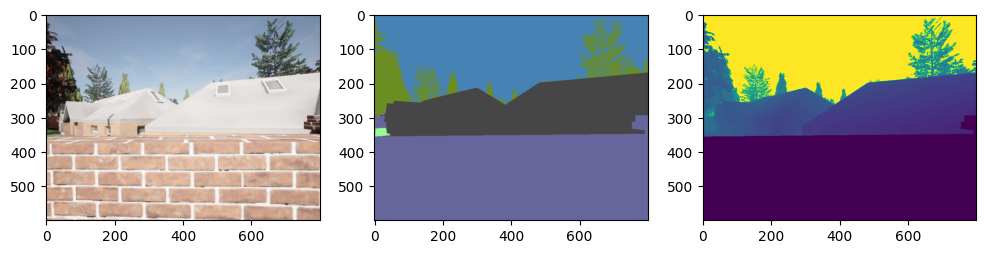

In [16]:
img = mpimg.imread("test_images/%06d.png" % image.frame)
img_semseg = mpimg.imread("test_images/%06d_semseg.png" % image.frame)
img_depth = mpimg.imread("test_images/%06d_depth.png" % image.frame)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,18))
ax1.imshow(img)
ax2.imshow(img_semseg)
ax3.imshow(img_depth) 
plt.show()

In [19]:
m= world.get_map()
waypoint = m.get_waypoint(transform.location)

In [22]:
waypoint = random.choice(waypoint.next(1)) #navigate to next waypoint on map 1.5 meters ahead
vehicle.set_transform(waypoint.transform)

In [25]:
random.choice(waypoint.next(1))